# Anomaly Detection using Autoencoder



We are going perform unsupervised anomaly detection on the voltage Time series. We are going to train our model in our normal dataset and then we will test it on the given abnormal dataset to test its ability to spot anomalies. The autoencoder will try to reproduce the given input, but since it is trained on the normal dataset, the reconstruction error of the abnormal samples should be larger that the error on the normal dataset.So by setting a threshold on this reconstruction error we can detect outliers on anomalies.

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import seaborn as sns
from pylab import rcParams
from sklearn.utils import shuffle
from pdb import set_trace
import matplotlib.pylab as plt
import sys
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.utils.multiclass import unique_labels

In [3]:
'''
 ' Huber loss.
 ' https://jaromiru.com/2017/05/27/on-using-huber-loss-in-deep-q-learning/
 ' https://en.wikipedia.org/wiki/Huber_loss
'''
def huber_loss(y_true, y_pred, clip_delta=1.0):
  error = y_true - y_pred
  cond  = tf.keras.backend.abs(error) < clip_delta

  squared_loss = 0.5 * tf.keras.backend.square(error)
  linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)

  return tf.where(cond, squared_loss, linear_loss)

'''
 ' Same as above but returns the mean loss.
'''
def huber_loss_mean(y_true, y_pred, clip_delta=1.0):
  return tf.keras.backend.mean(huber_loss(y_true, y_pred, clip_delta))

The loss function we used in training our models is Huber loss, since it is more less sensitive to outliers than squared error loss.

In [4]:
sys.path.append('/home/aggelos-i3/ForecastingLib/')
from tsutils import SequenceSpliter

In [5]:
rcParams['figure.figsize'] = 20, 12
sns.set()

## Preprocessing

In this step we chose the features our model is going to use. To reduce noise we use a moving average of the ten most recent samples, smoothing our sequences making it easier for our models to learn the underlying features. 

In [6]:
LOOKBACK = 100
LOOK_AHEAD = 1
ROLL_WINDOW = 10
features=['voltage [V]', 
          'acceleration (actual) [m/(s*s)]', 
          'tractive effort (actual) [kN]',
           'track-earth voltage [V]',
          'speed (actual) [km/h]',
          'current [A]',
          'energy balance [kWh]',
          'way (actual) [km]',
          'line and running resistance [kN]',
          'train configuration [1]',
          'energy input [kWh]',
          'train configuration [1]',
          'usable braking energy [kWh]',
          'used braking energy [kWh]'
         ]
nb_features = len(features)

In [7]:
df_list = []
#df_new = pd.DataFrame()
pathlist = Path("/home/aggelos-i3/Downloads/simu Elbas/7h33NO").glob(
    '**/*.xls')
for path in pathlist:
    path_in_str = str(path)
    df = pd.read_csv(path_in_str, delimiter='\t', usecols=features)
    df = df[:1000].rolling(window=ROLL_WINDOW).mean().dropna()
    df_list.append(df)

In [8]:
df_new = np.zeros((len(df_list)*len(df_list[0]), nb_features-1))
df_count=0
for df in df_list:
    for row in range(len(df)):
        df_new[row+df_count] = df.iloc[row]
    df_count += len(df)

Therefore we have a new smoothed dataset of the features we chose. We standarize our dataset featurewise, so that every column has a mean of 1 and a variation of 0. 

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
y_idx = df.columns.get_loc('voltage [V]') #which series we try to replicate
scaler = scaler.fit(df_new)
df_scaled = scaler.transform(df_new)
spliter = SequenceSpliter(lookback=LOOKBACK, look_ahead=LOOK_AHEAD)

We split our timeseries into sequences of 100 samples with one step difference. And we select the feature we want our autoencoder to reproduce, in our case the __Voltage__.

In [10]:
X, y = spliter.fit_transform(df_scaled)
y = y[:, :, y_idx] 

The choice of the preprocessing hyperparameters, like the window for the smoothing and the splitting window, is empirical and based on trial and error. 

We are going to implement and test 2 neural network autoencoders. One using recurrent cells (GRUs or LSTMs) and the second one is a convolutional autoencoder.

### Reccurent Autoencoder

Here we define and train our reccurent autoencoder.

In [11]:
inputs = Input(shape=X.shape[1:])
encoder = GRU(LOOKBACK, return_sequences=True)(inputs)
encoder = Dropout(0.7)(encoder)
encoder = GRU(32, return_sequences=True)(encoder)
encoder = Dropout(0.7)(encoder)
encoder = GRU(4, return_sequences=True)(encoder)
decoder = GRU(32, return_sequences=True)(encoder)
decoder = Dropout(0.7)(decoder)
out = GRU(LOOKBACK, return_sequences=False)(decoder)
LSTM_AE = Model(inputs, out)
LSTM_AE.compile(loss=huber_loss_mean, optimizer='adam')




In [13]:
history = LSTM_AE.fit(X, X[:,:,y_idx], epochs=50, validation_split=0.1, verbose=1)
history = pd.DataFrame(history.history)
history.plot()

Train on 17748 samples, validate on 1972 samples
Epoch 1/50
17748/17748 [==============================] - 87s 5ms/step - loss: 0.2741 - val_loss: 0.2249
Epoch 2/50
17748/17748 [==============================] - 87s 5ms/step - loss: 0.2287 - val_loss: 0.2013
Epoch 3/50
17748/17748 [==============================] - 84s 5ms/step - loss: 0.2056 - val_loss: 0.1803
Epoch 4/50
17748/17748 [==============================] - 84s 5ms/step - loss: 0.1859 - val_loss: 0.1566
Epoch 5/50
17748/17748 [==============================] - 84s 5ms/step - loss: 0.2031 - val_loss: 0.2824
Epoch 6/50
17748/17748 [==============================] - 86s 5ms/step - loss: 0.2124 - val_loss: 0.1596
Epoch 7/50
17748/17748 [==============================] - 88s 5ms/step - loss: 0.1689 - val_loss: 0.1494
Epoch 8/50
17748/17748 [==============================] - 85s 5ms/step - loss: 0.1592 - val_loss: 0.1362
Epoch 9/50
17748/17748 [==============================] - 84s 5ms/step - loss: 0.1524 - val_loss: 0.1313
Epoch 

KeyboardInterrupt: 

### Convolutional Autoencoder

In [ ]:
inputs = Input(shape=X.shape[1:])
encoder = Conv1D(LOOKBACK, 50, padding='same')(inputs)
encoder = BatchNormalization()(encoder)
encoder = Activation('relu')(encoder)
encoder = Conv1D(16, 25, padding='same')(encoder)
encoder = BatchNormalization()(encoder)
encoder = Activation('relu')(encoder)
encoder = Conv1D(8, 15, padding='same')(encoder)
encoder = BatchNormalization()(encoder)
encoder = Activation('relu')(encoder)
decoder = Conv1D(16, 25, padding='same')(encoder)
decoder = BatchNormalization()(decoder)
decoder = Activation('relu')(decoder)
decoder = Conv1D(LOOKBACK, 50, padding='same')(decoder)
out = GlobalAveragePooling1D()(decoder)
#out = Dense(LOOKBACK)(decoder)
FCN_AE = Model(inputs, out)
FCN_AE.compile(loss=huber_loss_mean, optimizer='adam')
FCN_AE.summary()

In [ ]:
history = FCN_AE.fit(X, X[:,:,y_idx], epochs=125, validation_split=0.1, verbose=1)
history = pd.DataFrame(history.history)
history.plot()

In [ ]:
inputs = Input(shape=X.shape[1:])

encoder = Conv1D(LOOKBACK, 48, padding='same')(inputs)
encoder = BatchNormalization()(encoder)
encoder = Activation('relu')(encoder)
encoder = MaxPooling1D()(encoder)

encoder = Conv1D(16, 24, padding='same')(encoder)
encoder = BatchNormalization()(encoder)
encoder = Activation('relu')(encoder)
encoder = MaxPooling1D()(encoder)

encoder = Conv1D(8, 12, padding='same')(encoder)
encoder = BatchNormalization()(encoder)
encoder = Activation('relu')(encoder)

decoder = UpSampling1D()(encoder)
decoder = Conv1D(16, 24, padding='same')(decoder)
decoder = BatchNormalization()(decoder)
decoder = Activation('relu')(decoder)

decoder = UpSampling1D()(decoder)
decoder = Conv1D(LOOKBACK, 48, padding='same')(decoder)
out = GlobalAveragePooling1D()(decoder)
CN_AE = Model(inputs, out)
CN_AE.compile(loss=huber_loss_mean, optimizer='adam')
CN_AE.summary()

In [ ]:
history = CN_AE.fit(X, X[:,:,y_idx], epochs=125, validation_split=0.1, verbose=0)
history = pd.DataFrame(history.history)
history.plot()

## Experiments

As a reconstruction error we use the mean squaered error of our predictions. Below we plot the reconstruction error for each type of simulated error and the detected anomalies. 

In the example tests the convolutional autoencoder showed superior training time. 

In [48]:
ERROR_TYPE = [1, 2, 3] #we can hav different labels for each error or the same label?
max_range = 800
min_range = 0
DATASET_IDX = 0

def model_test(model, min_range, dataset_idx):
    i=1
    for error_type in ERROR_TYPE:
        df_faulty = pd.DataFrame()
        s = 0.
        pathlist = Path(f"/home/aggelos-i3/Downloads/simu Elbas/7h33D{error_type}").glob(
            '**/*.xls')

        for path in pathlist:
            path_in_str = str(path)
            df = pd.read_csv(path_in_str, delimiter='\t', usecols=features)
            if df_faulty.empty:
                df_faulty = df[:1000]
            else:
                df_faulty += df[:1000]
            s += 1.

        df_faulty /= s
        df_faulty = df_faulty.rolling(window=ROLL_WINDOW).mean().dropna()
        y_idx = df_faulty.columns.get_loc('voltage [V]')
        df_scaled_faulty = scaler.fit_transform(df_faulty)
        X_test, y_test = spliter.fit_transform(df_scaled_faulty)
        #X_test = np.delete(X_test, y_idx, 2)
        y_test = y_test[:, :, y_idx]

        yhat = model.predict(X_test)
        #yhat = yhat.reshape(X_test.shape)
        mse = np.mean(np.power(yhat-X_test[:,:,y_idx],2), axis=1)
        
        yhat_normal = model.predict(X)
        #yhat = yhat.reshape(X_test.shape)
        mse_normal = np.mean(np.power(yhat_normal-X[:,:,y_idx],2), axis=1)
        df_error = pd.DataFrame({
                                'Abnormal_reconstruction_error': mse,
                                'Label': y_test[:,0]
                                })
        df_error = df_error[:max_range]
        #df_error['reconstruction_error'].plot()
 
        threshold = mse.mean() + mse.std()
        normal_threshold = mse_normal.mean() + 0.5*mse_normal.std()

        anomaly = mse[min_range:max_range] > threshold
        plt.subplot(3,3,i)
        plt.title(f"Error Type {error_type}")
        plt.plot(df_error['Abnormal_reconstruction_error'][min_range:], label='Abnormal_Reconstruction Error')
        plt.axhline(y=threshold, color='r', linestyle='-', label='Abnormal_threshold')
        plt.legend(loc='best')


    
        plt.subplot(3,3,i+1)
        plt.scatter(range(min_range,max_range), np.where(anomaly, y_test[min_range:max_range, 0], None), c='r', label='Outliers')
        plt.plot(range(min_range,max_range), y_test[min_range:max_range,0], label='Abnormal Voltage')
        plt.legend(loc='best')
       

 
        anomaly = mse_normal[min_range:max_range] > normal_threshold
        plt.subplot(3,3,i+2)
        plt.scatter(range(min_range,max_range), np.where(anomaly, y_test[min_range:max_range, 0], None), c='r', label='Outliers')
        plt.plot(range(min_range,max_range), y[min_range:max_range,0], label='Normal Voltage')
        plt.legend(loc='best')

        i+=3
    

### AutoEncoder with Maxpooling Regularization

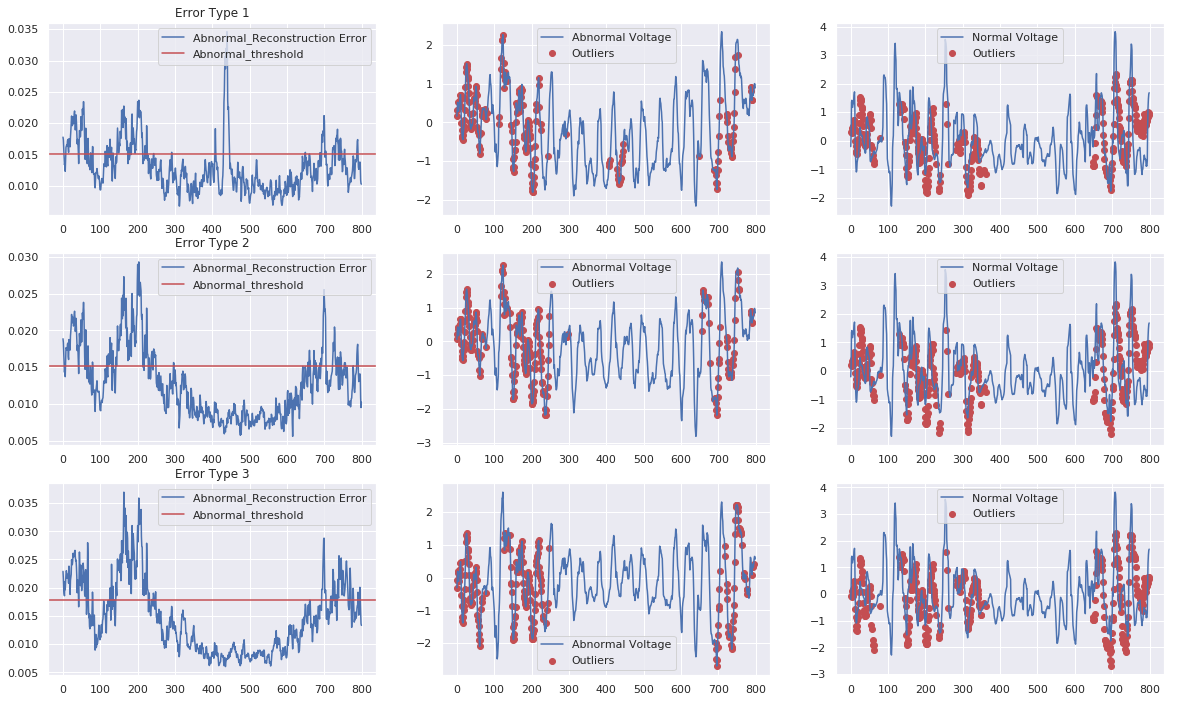

In [49]:
model_test(CN_AE, min_range=0, dataset_idx=0)

### Autoencoder without Max Pooling

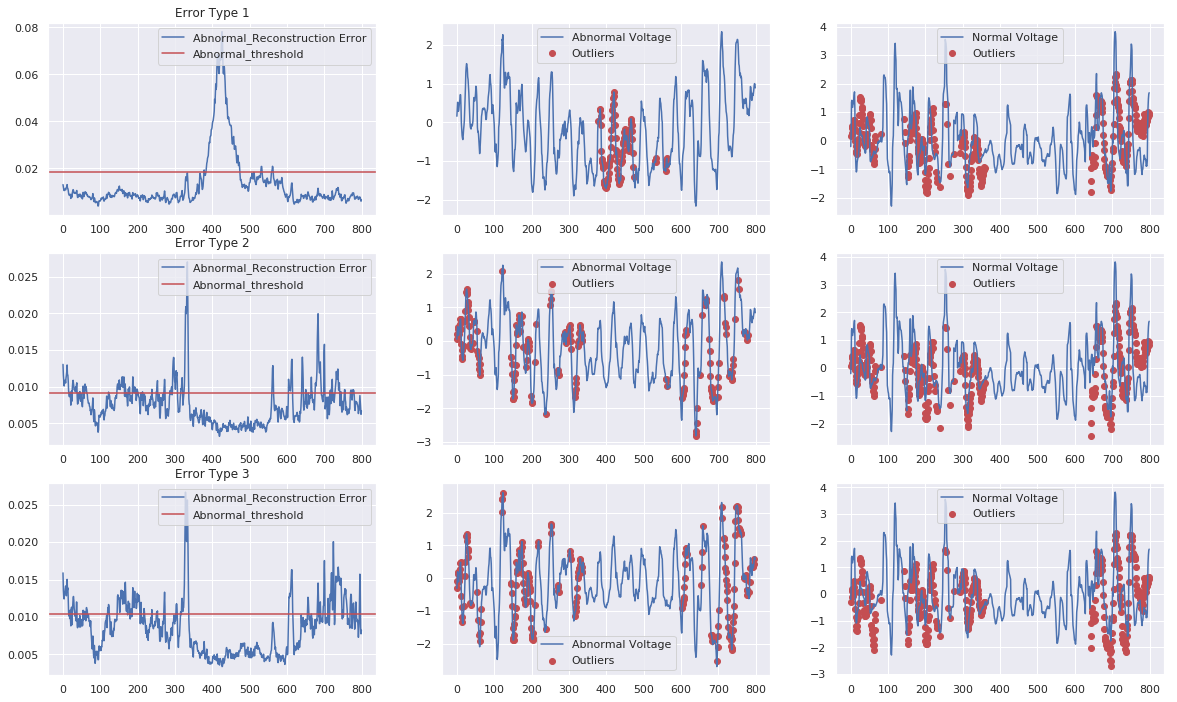

In [50]:
model_test(FCN_AE, min_range=0, dataset_idx=15)

### LSTM Autoencoder

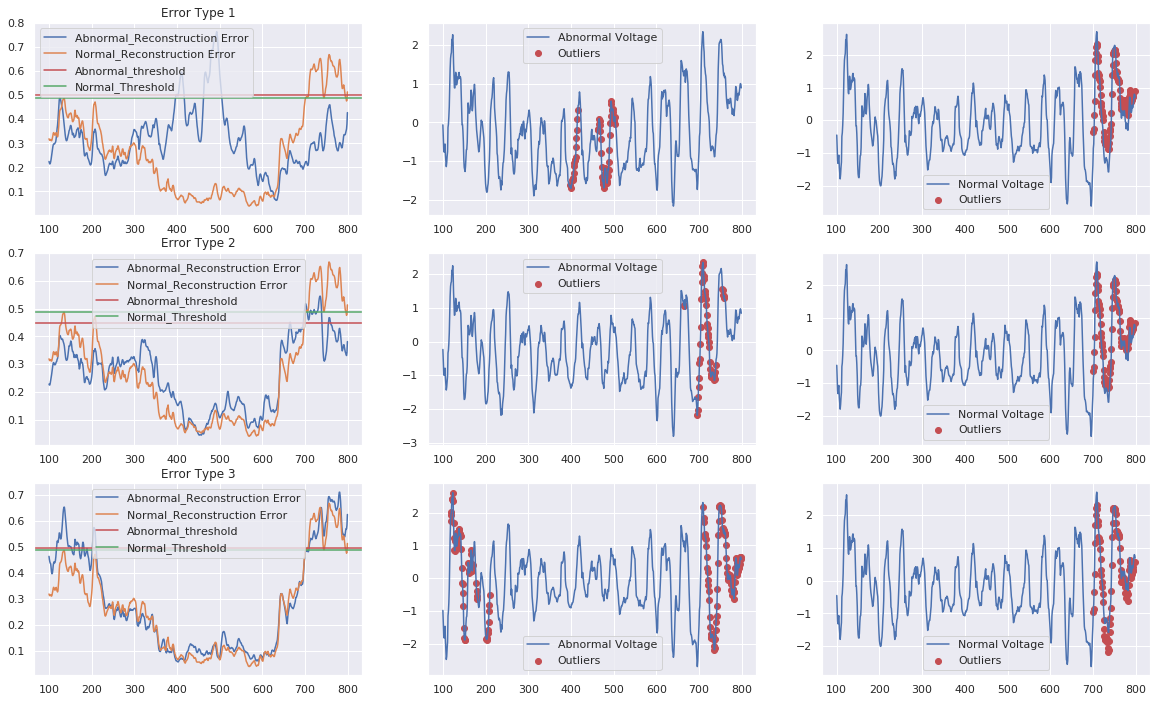

In [60]:
model_test(LSTM_AE, min_range=100, dataset_idx=1)

In [15]:
tf.keras.utils.plot_model(CN_AE, 'cn_ae.png')